# Weekly Social Media Mentions

## Executive Summary

With 628 days worth of social media mentions, the goal was to produce a model that forecasts the weekly social media mentions for a client.

In total, four models were produced to forecast weekly social media mentions: two of them baseline models, one a statistics-based forecasting model (SARIMAX), and one a Random Forest model. 

The SARIMAX was chosen over other statistical models, such as vector autoregressive, because the data is univariate. The SARIMAX model also has the advantage of the Wold decomposition theorem, which states that any stationary data can be modeled using an ARMA model (ARMA being a sub-class of SARIMAX). 

The Random Forest was selected over other machine learning algorithms as decision trees are easily explainable and perform well with structured data.

The results of each model's performance on the test set are shown below:

|      Model        | Root Mean Squared Error | Mean Absolute Percent Error | $r^2$  |
|:--------------|:-------------------------:|:-----------------------------:|:------:|
| Random Forest | 300,000              | 21.07                       | 0.88 |
| Average      | 334,000               | 38.78                       | 0.77 |
| SARIMAX      | 457,000               | 49.43                       | 0.35 |
| Naive        | 536,000               | 60.40                       | 0.17 |

The Random Forest model had the best metrics across the board. 

I suspect the Random Forest received a boost due to the added feature engineering done specifically for the model. Furthermore, Random Forests are known to do extremely well with structured data. 

Moving forward, I would reevaluate the SARIMAX model using the new features, as well as other statistical modeling approaches such as the ARCH (autoregressive conditional heteroskedasticity) model, which takes into account nonuniform variance, and the VAR (vector autoregression) model, which excels at multivariate forecasting.

Additional tuning and examination of the Random Forest hyperparameters should be done if it remains a desirable model.

Overall, the Random Forest model represents a well-performing and explainable model that should be used as a baseline for future models moving forward.

In [1]:
import warnings
from itertools import product
from functools import partial

import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn import metrics

from scipy.stats import ttest_ind, probplot, boxcox, uniform, randint

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

from pylab import rcParams


from IPython.display import Image, display, Math, Latex

plt.rcParams.update({'figure.figsize':(15,8)})
plt.style.use('ggplot')
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

np.random.seed(1)

# Import Data

In [2]:
# Read Data
data = pd.read_json("data.json")
# read in time-series data
timeseries = pd.DataFrame(data.loc['volume_aggs', 'aggregations']['buckets'])
timeseries.rename(columns= {'key_as_string': 'date', "key":"datetime", "doc_count": "mentions"}, inplace= True) # better feature names

In [3]:
timeseries['date'] = pd.to_datetime(timeseries['date']) # convert to datetime
timeseries.set_index("date", inplace= True)
timeseries.drop('datetime', axis= 1, inplace= True)

In [4]:
# quick glance at data and sanity check
print("Shape of data: ", timeseries.shape)
timeseries.head()

Shape of data:  (628, 1)


,mentions
date,
2019-07-25 00:00:00+00:00,969
2019-07-26 00:00:00+00:00,1802
2019-07-27 00:00:00+00:00,1773
2019-07-28 00:00:00+00:00,2239
2019-07-29 00:00:00+00:00,1325


## Train/Validation/Test

Given the nature of time series data, the train, validation, and test splits are all chronological, meaning that train is before validation, which is before test.

Here, I used the 20% of the data for test, 20% of the remaining data for validation, and the rest for training.  

In [5]:
test_start = '2020-12-07'
val_start = '2020-08-24'
train_start = '2019-07-25'

test = timeseries[timeseries.index >= test_start].copy()
val = timeseries[(timeseries.index < test_start) & (timeseries.index >= val_start)].copy()
train = timeseries[timeseries.index < val_start].copy()
train_and_val = timeseries[(timeseries.index < test_start)].copy()

In [6]:
# Goal is to predict weekly social media mentions
weekly = timeseries.resample("1w").sum()
weekly.reset_index(inplace= True)

train_weekly = train.resample("1w").sum()
train_weekly.reset_index(inplace= True)

val_weekly = val.resample("1w").sum()
val_weekly.reset_index(inplace= True)

train_and_val_weekly = train_and_val.resample("1w").sum()
train_and_val_weekly.reset_index(inplace= True)

test_weekly = test.resample("1w").sum()
test_weekly.reset_index(inplace= True)

# Exploratory Data Analysis

In [7]:
# no missing values
timeseries.mentions.isna().sum() 

0

In [8]:
timeseries.mentions.describe()

count       628.000000
mean     166755.590764
std      132322.370901
min          17.000000
25%       51706.500000
50%      106877.000000
75%      298622.750000
max      667893.000000
Name: mentions, dtype: float64

**The data is very clean. No further preprocessing appears to be needed.**

## Distribution

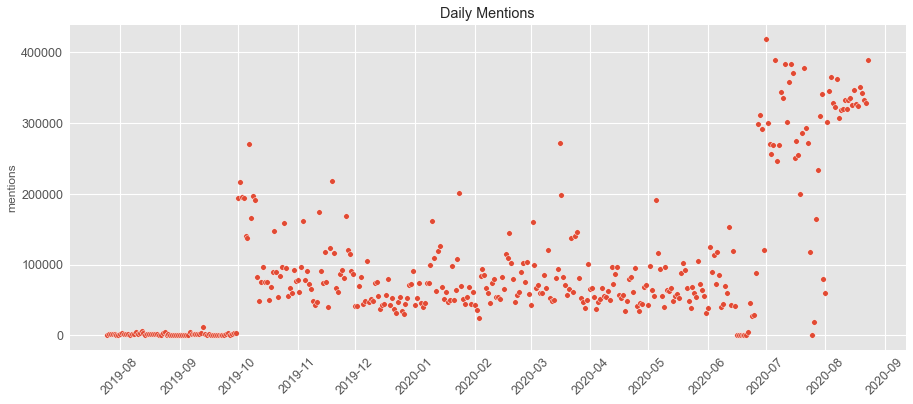

In [9]:
# Basic Visualization
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(x= 'date', y= 'mentions', data= train, ax= ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.xlabel("")
plt.title("Daily Mentions")
plt.show()

It looks like there three distinct time periods worth looking at. The first initial set of mentions hovering at around 1000, a second set of mentions at 100,000, and then what appears to be a spike starting in July 2020.

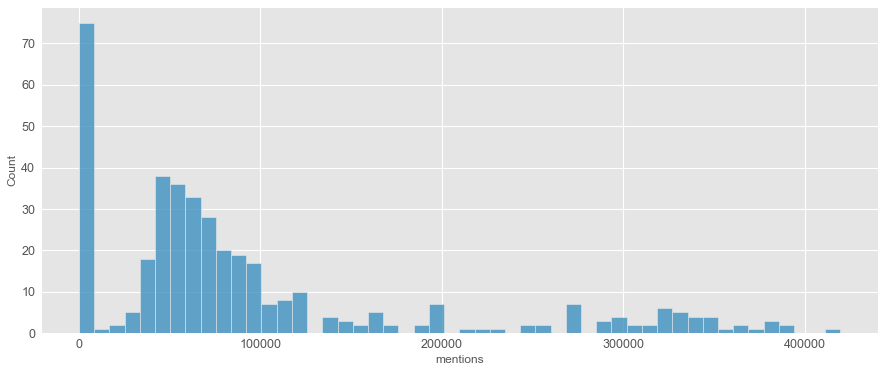

In [10]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(data= train.mentions.sort_values().reset_index(drop= True),
             bins = 50,
             ax = ax);

The histogram confirms what we noted above, that there are two time periods: one hovering at 1000 mentions and another group that averages to be closer to 60,000 mentions. Finally, we know there is a spike at the end of our training data.

## Normality

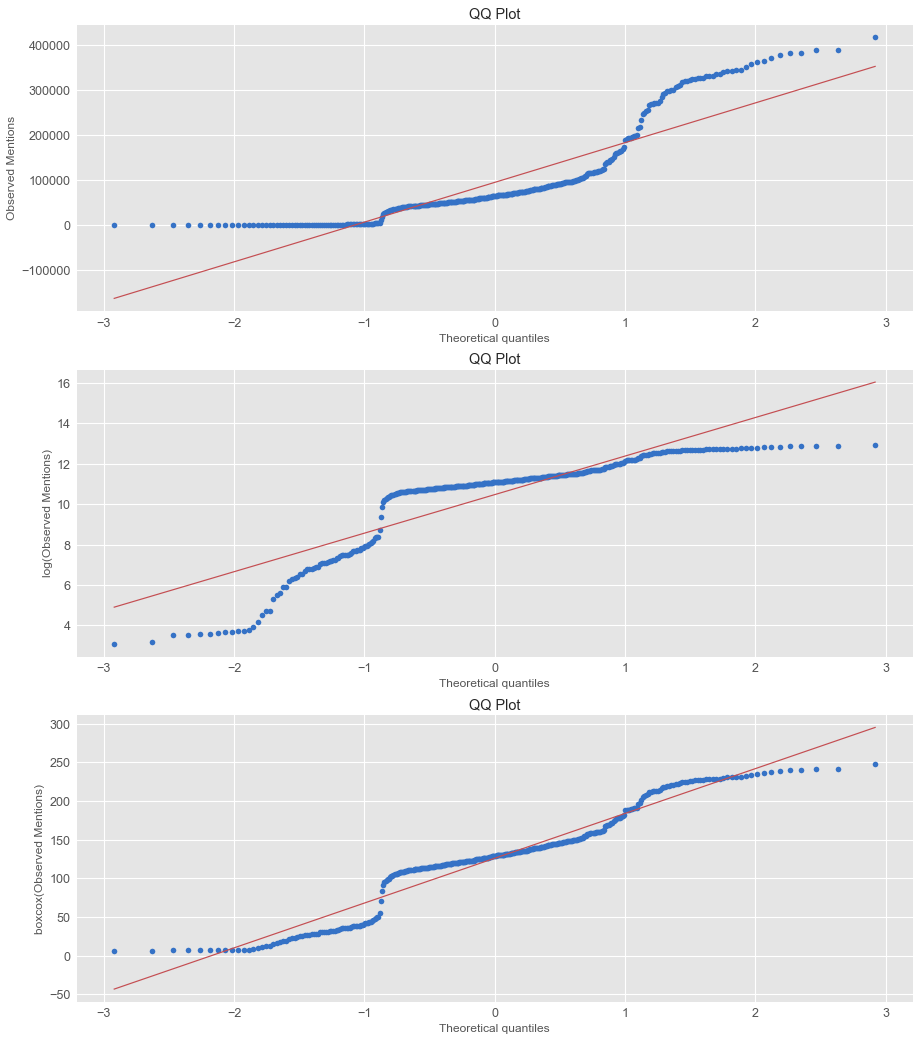

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15,18))
probplot(train.mentions, dist = 'norm', plot = ax[0])
probplot(np.log(train.mentions), dist = 'norm', plot = ax[1])
xt, _ = boxcox(train.mentions)
probplot(xt, dist= 'norm', plot = ax[2])
ax[0].set_title("QQ Plot"); ax[0].set_ylabel("Observed Mentions")
ax[1].set_title("QQ Plot"); ax[1].set_ylabel("log(Observed Mentions)")
ax[2].set_title("QQ Plot"); ax[2].set_ylabel("boxcox(Observed Mentions)"); 

The QQPlots above show that the data deviates heavily from normality, and that log and Box-Cox transformations only slightly help.

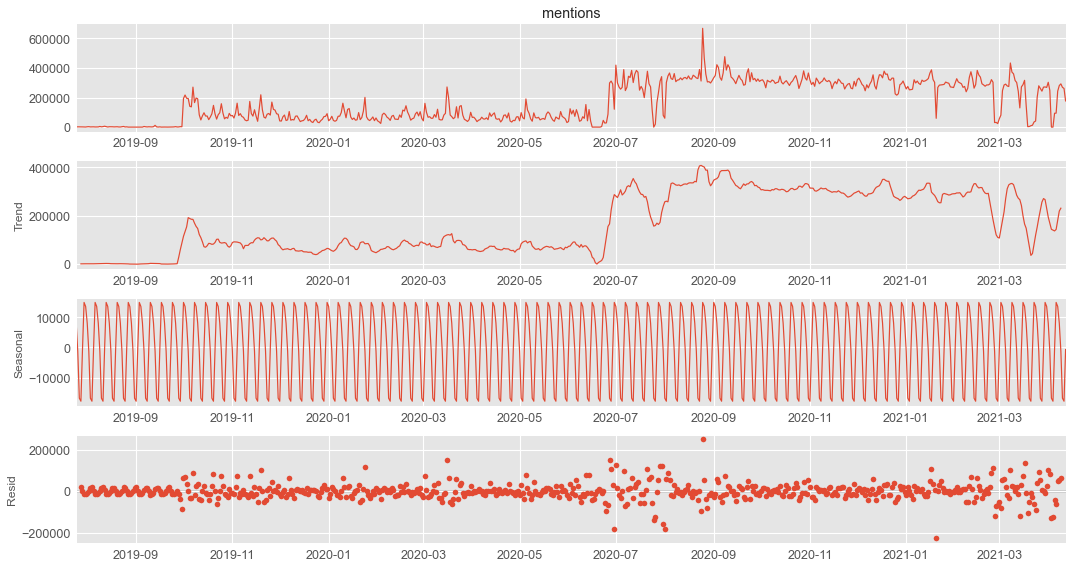

In [12]:
decomposition = sm.tsa.seasonal_decompose(timeseries.mentions, model='additive')
fig = decomposition.plot()
plt.show()

The decomposed plots show no seasonality and no pattern in residuals from a first glance.

Predict the weekly social mentions given the dataset.  
The weekly mentions are shown in the plot below.

**Predicting weekly mentions presents an interesting challenge as aggregating the daily data to weekly data effectively reduces our data by 7x.**

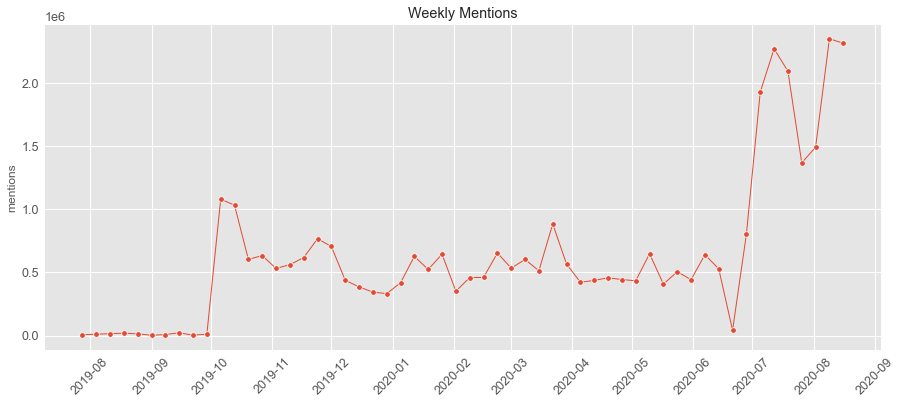

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x= 'date', y = 'mentions', marker= 'o', linewidth = 1, data = train_weekly.reset_index()[0:-1], ax = ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.xlabel("")
plt.title("Weekly Mentions")
plt.show()

## Do weekends get special attention?

In [14]:
train.reset_index(inplace= True)
train['is_weekend'] = train.date.apply(lambda x: x.weekday() > 5)
train.set_index('date', inplace= True)
print(f"Weekend Daily Average: {train[train.is_weekend == True].mentions.mean():.2f}")
print(f"Weekday Daily Average: {train[train.is_weekend == False].mentions.mean():.2f}")

Weekend Daily Average: 86309.26
Weekday Daily Average: 96938.11


The two-sample t-test is set up as follows:  
&emsp; $H_0$: $\mu_{weekend} = \mu_{weekday}$  
&emsp; $H_a$: $\mu_{weekend} \neq \mu_{weekday}$  

In [15]:
weekend_boost = ttest_ind(train[train.is_weekend == True].mentions, train[train.is_weekend == False].mentions)
round(weekend_boost.pvalue, 3)

0.453

**Weekends are not special...yet.**

With a p-value of 0.453, we fail to reject the null hypothesis that the average weekend social mention are equal to the average weekday social mention. That being said, there is an observable difference between the average weekday and weekend. This should be something that is revisited with more data.

## Do specific days get more mentions?

In [16]:
def int_to_day(i):
    week_dict = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday',
    }
    
    return week_dict[i]

In [17]:
train.reset_index(inplace= True)
train['weekday'] = train.date.apply(lambda x: int_to_day(x.weekday()))
train.set_index('date', inplace= True)

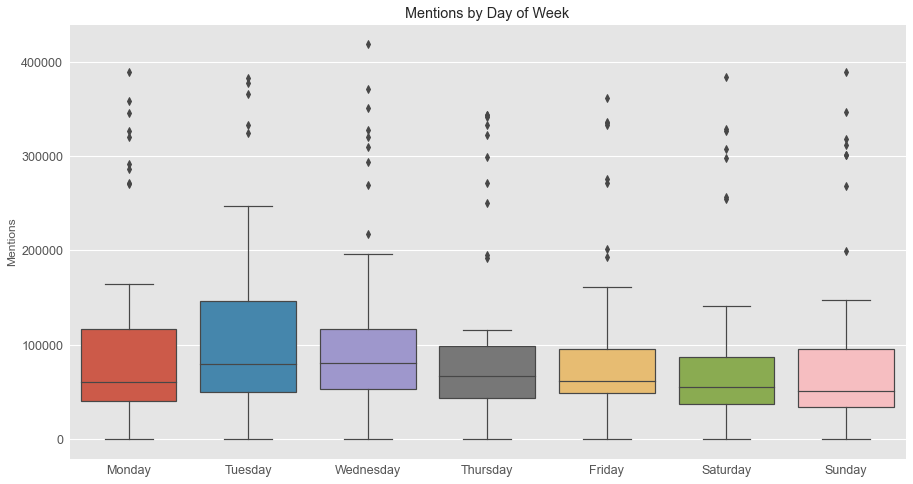

In [18]:
# throw in ylabel and  title
fig, ax = plt.subplots()
sns.boxplot(y = 'mentions', x = 'weekday', data= train, ax= ax, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel("")
ax.set_ylabel("Mentions")
ax.set_title("Mentions by Day of Week");

**No single day stands out**, however it is worth noting that mentions tend to skew right, meaning a lot of positive outliers tend to occur.

In [19]:
def sorted_boxplot(df, by, column, ascending = True, ax = None):
    """
    :type df:       pandas.DataFrame
    :type by:       str
    :type column:   str
    :type asending: bool
    :type ax:       matplotlib.axes.Axes
    
    :rtype:         matplotlib.figure.Figure
    """
    d = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    medians = d.median().sort_values()

    if ascending:
        return sns.boxplot(data= d[medians.index], ax = ax)
    else:
        return sns.boxplot(data= d[medians.index[::-1]], ax = ax)

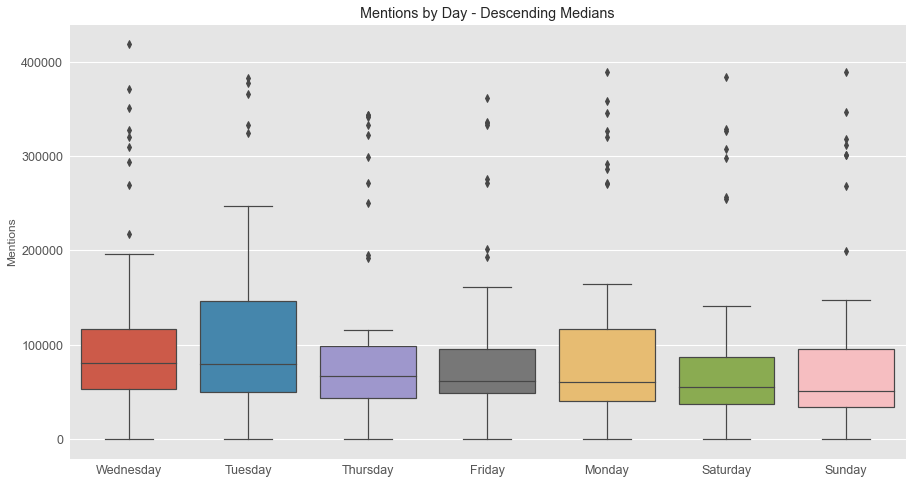

In [20]:
# Sorted Boxplot by median
fig, ax = plt.subplots()
sorted_boxplot(train, 'weekday', 'mentions', ascending= False, ax= ax)
ax.set_title("Mentions by Day - Descending Medians")
ax.set_ylabel("Mentions");

I find it interesting that Saturday and Sunday typically have the lowest social mentions. 

# Model Metrics

Before diving into the models, I wanted to take a minute to go into the three metrics used for model evaluation.

**Mean Absolute Percent Error**

$MAPE = \frac{1}{N}\sum^N_{i=1} \frac{|y_i - \hat y_i|}{|y_i|}\cdot 100\%$

The first one is the Mean Absolute Percent Error (MAPE). MAPE is good for time-series analysis as it represents a unitless metric that can compare across models.

**Root Mean Squared Error**  
$RMSE = \sqrt{\frac{\sum^N_{i=1}(x_i-\hat x_i)^2}{N}}$

Root Mean Squared Error is a measure of how far the model is from the true data points. RMSE is generally a good loss function to optimize on.

**Coefficient of Determination or R-Squared**  
$r^2 = \big(\frac{cov(X,Y)}{\sigma_x \sigma_Y}\big)^2$

R-squared is the general association between two variables as determined by their covariance and standard errors. Another interpretation of the $r^2$ is the amount of variance captured or explained by the model.

In [21]:
def forecast_accuracy(actual, forecast):
    mape = 100*(np.mean(np.abs(forecast - actual)/np.abs(actual))) 
    rmse = np.mean((forecast - actual)**2)**.5
    corr = (np.corrcoef(forecast, actual)[0,1])**2
    return({'rmse': rmse,
            'mape': mape, 
            'r2': corr})

# Models

## Baseline Models

As with any model, it is good to establish a baseline using naive models to determine the additional value that a more complicated model will bring. Here, I establish two baseline models.

### Baseline 1 - Lag1 Model

The model here is simple: use the previous datapoint as the predictor for the following datapoint. This is a simple rules-based model that performs quite well in many cases.

In [22]:
# Naive Model - predict previous data point (lag1 series)
train_and_val_weekly['naive'] = pd.concat([pd.Series(0), weekly.mentions]).reset_index(drop = True).copy()
val_weekly['naive'] = pd.concat([pd.Series(val_weekly.mentions.mean()), val_weekly.mentions]).reset_index(drop = True).copy()
test_weekly['naive'] = pd.concat([pd.Series(test_weekly.mentions.mean()), test_weekly.mentions]).reset_index(drop = True).copy()

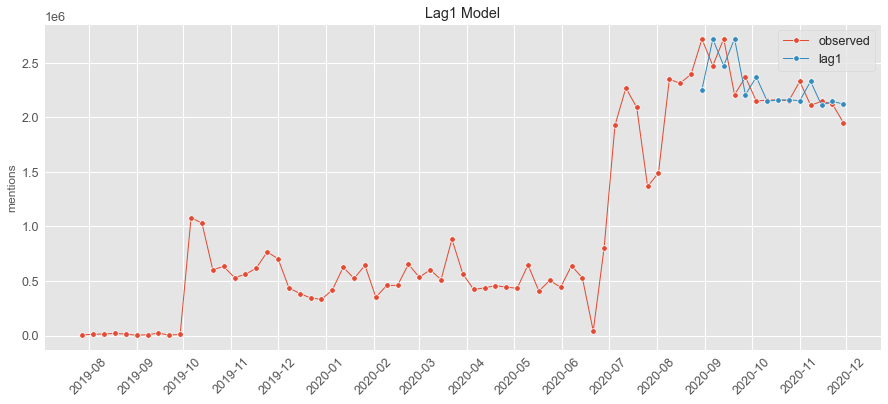

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x= 'date', y = 'mentions', marker= 'o', linewidth = 1, data = train_and_val_weekly[0:-1], ax = ax)
sns.lineplot(x= 'date', y = 'naive', marker= 'o', linewidth = 1, data = val_weekly[0:-1], ax = ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.xlabel("")
plt.legend(["observed", "lag1"])
plt.title("Lag1 Model")
plt.show()

### Baseline 2 - Rolling Average Model

The following model also makes a lot of practical sense. We use the average of the previous datapoints to predict the following one. This model is influenced less by any single point, unlike the previous baseline model.

In [24]:
# Rolling Average Model - based on last 5 points
train_and_val_weekly['average'] = train_and_val_weekly.mentions.rolling(5).mean()
train_and_val_weekly.average.fillna(method= 'bfill', inplace= True) # Backfill data

val_weekly['average'] = val_weekly.mentions.rolling(5).mean()
val_weekly.average.fillna(method= 'bfill', inplace= True)

test_weekly['average'] = test_weekly.mentions.rolling(5).mean()
test_weekly.average.fillna(method= 'bfill', inplace= True)

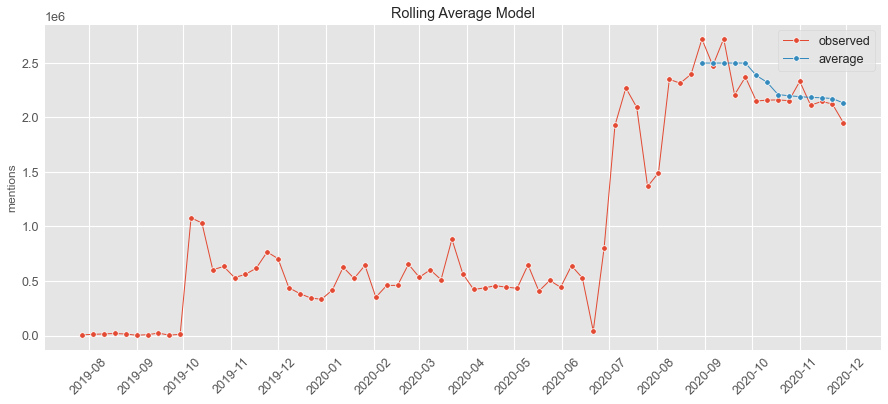

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x= 'date', y = 'mentions', marker= 'o', linewidth = 1, data = train_and_val_weekly.reset_index()[0:-1], ax = ax)
sns.lineplot(x= 'date', y = 'average', marker= 'o', linewidth = 1, data = val_weekly.reset_index()[0:-1], ax = ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.xlabel("")
plt.legend(["observed", "average"])
plt.title("Rolling Average Model")
plt.show()

## SARIMAX Model 

Now that I have established my baseline models, I use a classic time-series forecasting model called a SARIMAX (non-stationary seasonal autoregressive integrated moving average with exogenous regressors) model.

The SARIMAX model is the most generic form of ARIMA-type models. It is able to be simplified into more specific models such as the AR, MA, and ARMA models by adjusting model parameters.

I started with the SARIMAX model for a few reasons:

1. It is a linear model for forecasting data. With the low amount of data we starting with (628 (daily) data points -> 90 (weekly) data points), a basic model tends to perform well.

2. It is a univariate timeseries. If this were a multivariate timeseries, I would look into a Vector Autoregression (VAR) model. VAR models are exceptional at capturing relationships between multiple changing quantities.

3. Any stationary model can be modeled with a stationary ARIMA model via the [Wold Decomposition Theorem](https://en.wikipedia.org/wiki/Wold%27s_theorem).

**SARIMAX Model Parameters:**

* d - differencing (I) parameter that transforms non-stationary data to stationary
* p - autoregressive (AR) parameter that accounts for previous data in the same timeseries
* q - moving average (MA) parameter that accounts for previous error in the timeseries


### Integrated parameter (d)

The Integrated parameter `d` is 0 if we already have stationary data, or greater than 0 if we need to transform the data to make it stationary. To test for this, we use the Augmented Dickey Fuller (ADF) Test for stationary data.

The ADF test is set up as follows:  
&emsp; $H_0$: data is non-stationary  
&emsp; $H_a$: data is stationary (not non-stationary)

In [26]:
result = adfuller(train.mentions)
print(f'{"ADF Statistic:":>15} {result[0]:.2f}')
print(f'{"p-value:":>15} {result[1]:.3f}')

 ADF Statistic: -1.61
       p-value: 0.480


With a p-value of 0.480, we fail to reject null hypothesis.  
Therefore, we need to find the order of differencing needed to convert the data to a stationary time series.  
**I would expect that the differencing order `d` should be at least 1.**

### Autoregressive parameter (p)

The `p` sets the order of the autoregressive process defined below as:
$$x_t \equiv \alpha_1 x_{t-1} + \alpha_2 x_{t-2} +\ ...\ + \alpha_p x_{t-p} + w_t$$

In essence, the order `p` determines how far back you look into the same series to predict the future point.

In [27]:
train_and_val_weekly.set_index("date", inplace= True)
val_weekly.set_index("date", inplace= True)
test_weekly.set_index('date', inplace= True)
weekly.set_index('date', inplace= True)
plt.rcParams.update({'figure.figsize':(16,14)})

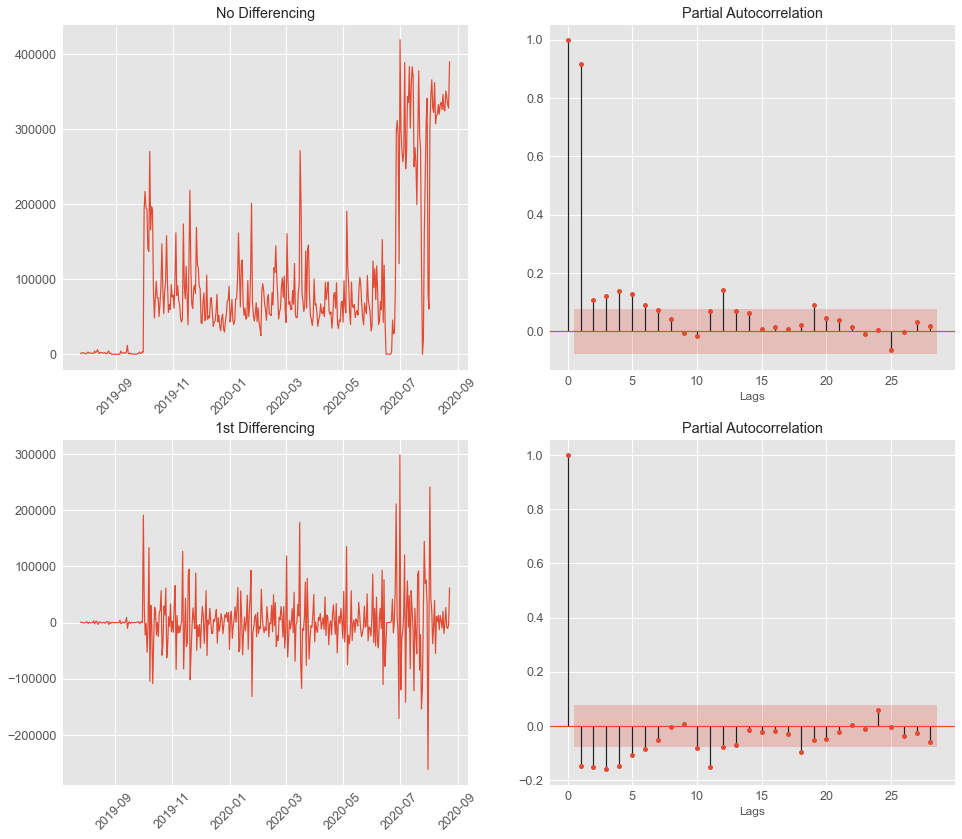

In [28]:
fig, ax = plt.subplots(2, 2)
ax[0][0].plot(train.mentions)
ax[0][0].set_title('No Differencing')
for tick in ax[0][0].get_xticklabels():
    tick.set_rotation(45)
plot_pacf(timeseries.mentions, ax=ax[0][1])
ax[0][1].set_xlabel("Lags")

ax[1][0].plot(train.mentions.diff())
ax[1][0].set_title('1st Differencing')
for tick in ax[1][0].get_xticklabels():
    tick.set_rotation(45)
plot_pacf(timeseries.mentions.diff().dropna(), ax=ax[1][1])
ax[1][1].set_xlabel("Lags")
plt.show()

Looking at the top right partial autocorrelation graph, we see that the first lag has a high correlation value (~0.9). That is, the previous data point is a very good predictor of the following point. As ARIMA models work best with stationary data, a high correlation is undesirable.

After taking the first difference, we see a great reduction in the Partial Autocorrelation lag values (bottom right).  
The first lag that drops into the 95% confidence interval is the 7th point, therefore I would set the autoregressive order `p` to be **at most 6.**

### Moving Average parameter (q) 

Similar to the autoregressive parameter, the moving average parameter `q` defines the linear combination of the white noise terms of the previous data points as shown below:

$$x_t \equiv  w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} +\ ...\ + \beta_q w_{t-q}$$

In contrast to the autoregressive term, the moving average parameter accounts for the previous errors as opposed to the actual values of the prior datapoints.

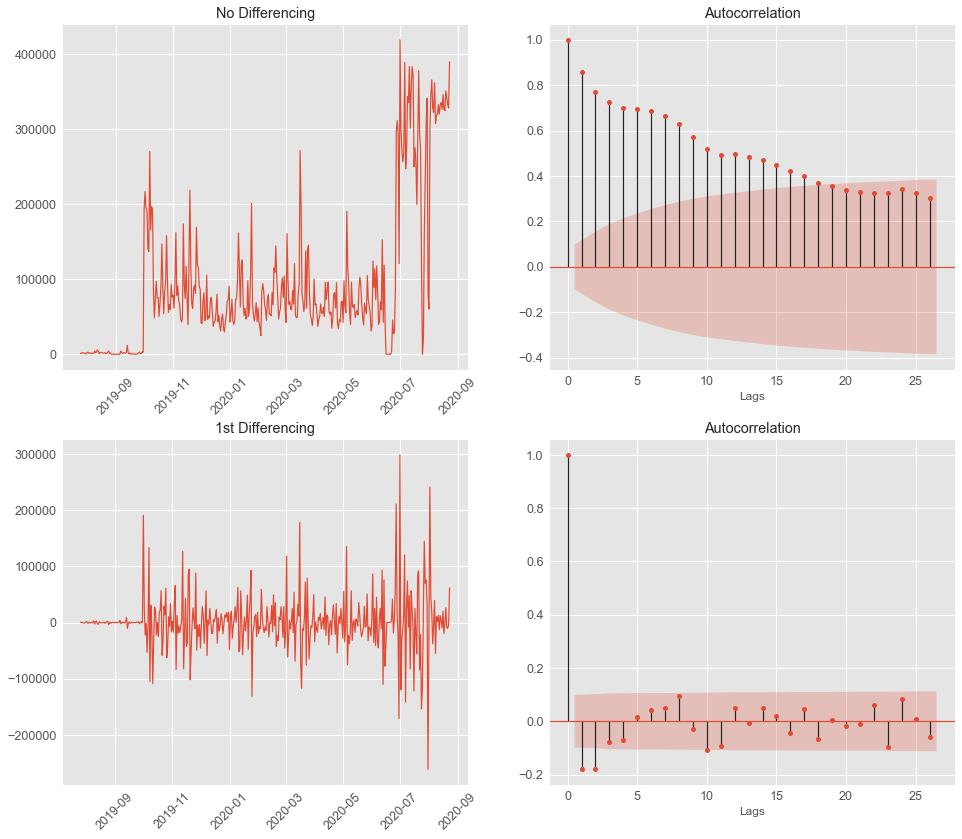

In [29]:
fig, ax = plt.subplots(2, 2)
ax[0][0].plot(train.mentions)
ax[0][0].set_title('No Differencing')
for tick in ax[0][0].get_xticklabels():
    tick.set_rotation(45)
plot_acf(train.mentions, ax=ax[0][1])
ax[0][1].set_xlabel("Lags")

ax[1][0].plot(train.mentions.diff())
ax[1][0].set_title('1st Differencing')
for tick in ax[1][0].get_xticklabels():
    tick.set_rotation(45)
plot_acf(train.mentions.diff().dropna(), ax=ax[1][1])
ax[1][1].set_xlabel("Lags")

plt.show()

Values inside the orange bar for the autocorrelation plot that are within the confidence interval are not significantly correlated with the previous point. We see that after a first order difference, the autocorrelations greatly decreased. The first lag that drops into the 95% confidence interval is 3. Therefore, I would set the autoregressive order `q` to be **at most 3.**

### Hyperparameter Tuning

We are scoring the SARIMAX model off the AIC (Akaike Information Criterion) which is an estimator of prediction error for statistical models. The formula and parameters are shown below:

$AIC = 2k - 2ln(\hat L)$  
&emsp; where  
&emsp; $k$ is the number of estimators  
&emsp; $\hat L$ is the maximum likelihood function for the model

Since the decomposition plot did not show any seasonal effects, we use the stationary ARIMA model over the SARIMAX model.

In [30]:
def _pdq_product(p_range, d_range, q_range, season = None):
    """
    :type p_range, d_range, q_range: list
    
    :rtype: list
    """
    pmin, pmax = p_range
    dmin, dmax = d_range
    qmin, qmax = q_range
    
    p = range(pmin, pmax)
    d = range(dmin, dmax)
    q = range(qmin, qmax)
    if season:
        return [(p_, d_, q_, season) for p_, d_, q_ in list(product(p, d, q))]
    else:
        return [(p_, d_, q_) for p_, d_, q_ in list(product(p, d, q))]

def sarimax_gridsearch(pdq, seasonal_pdq, verbose = False):
    """
    :type pdq:          list
    :type seasonal_pdq: list
    :type verbose:      bool
    
    :rtype: dict
    
    Example:
    >>> p = d = q = range(0, 2)
    >>> pdq = list(product(p, d, q))
    >>> seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
    >>> best_params = sarimax_gridsearch(pdq, seasonal_pdq)
    """
    # "GridSearch" for best parameters
    best_params= {'param': [], 'param_seasonal': [], 'aic': []}

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_and_val_weekly.mentions,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(maxiter= 200)
            if verbose:
                print(f'ARIMA:{param}x{param_seasonal} - AIC:{results.aic:.2f}')
            best_params['param'].append(param)
            best_params['param_seasonal'].append(param_seasonal)
            best_params['aic'].append(results.aic)
    
    return best_params

In [31]:
# Create stationary PDQs
p_range = [0,7]
d_range = [0,2]
q_range = [0,4]
pdq = _pdq_product(p_range, 
                   d_range, 
                   q_range)

# Set Seasonal PDQs to 0
PDQ = [(0, 0, 0, 12)]

In [32]:
# SARIMAX Gridsearch
best_params = sarimax_gridsearch(pdq, PDQ)

param, param_seasonal, aic = best_params['param'], best_params['param_seasonal'], best_params['aic']
sorted_params = pd.DataFrame([param, param_seasonal, aic], index= ['param', "param_seasonal", 'aic']).T
best_param = sorted_params.sort_values('aic')[:1]
best_param

,param,param_seasonal,aic
52,"(6, 1, 0)","(0, 0, 0, 12)",1834.71


The model with the lowest AIC is also the best performing model.  

I set upper bounds of 6 for p and 3 for q before performing the gridsearch based on the previous analysis.

In [33]:
model = sm.tsa.statespace.SARIMAX(train_and_val_weekly.mentions, # best params
                                  order=best_param.values[0][0],
                                  seasonal_order=best_param.values[0][1],
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
results = model.fit()

### Analysis

As seen in the graphs below, residuals are roughly normally distributed (centered at 0, with a less than 1 standard error), though a slight downward trending slope is observed. 

The QQ plot shows significant deviation from normality. 

The correlogram shows that the dataset is mostly random with low autocorrelation values that are not statistically significant, meaning the differencing taken from the data has made it stationary. Correlogram is made after differencing and reducing general trends and seasonal variations.

A few things to note here are the slight wave to the data in the QQ plot, the previous downward trending residuals, and slight wave in the correlogram. These signs point to heteroscedasticity (unequal variance across different time periods) in the data. One major assumption of the ARIMA model is the fact that the variance is constant throughout the time series. These notes provide evidence against this assumption.

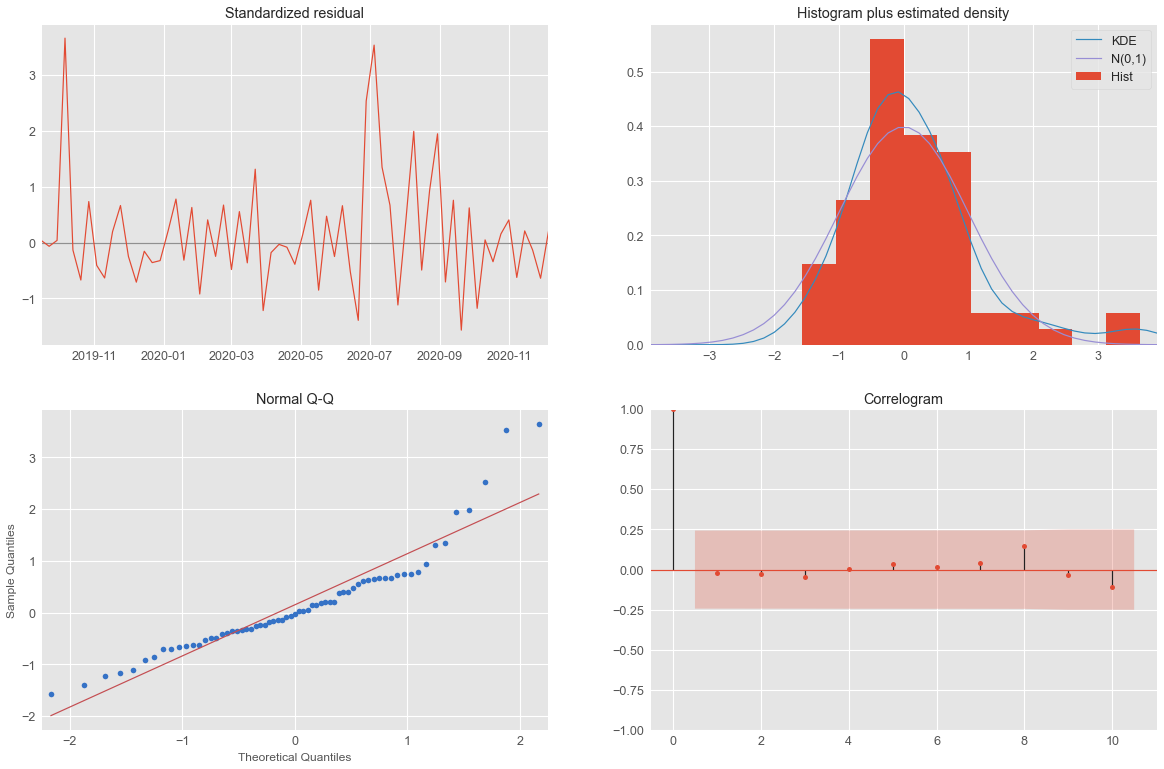

In [34]:
results.plot_diagnostics(figsize=(20, 13));

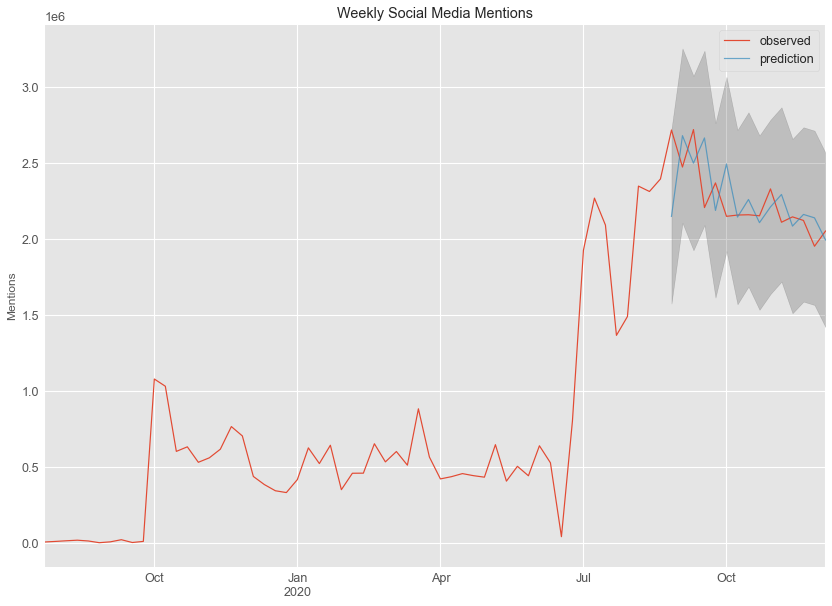

In [35]:
plt.rcParams.update({'figure.figsize':(15,10)})
pred = results.get_prediction(start=pd.to_datetime(val_weekly.index[0], utc= True), dynamic=False)
pred_ci = pred.conf_int()
ax = train_and_val_weekly[train_start:].mentions.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='prediction', alpha=.7, figsize=(14, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('')
ax.set_ylabel('Mentions')
ax.set_title("Weekly Social Media Mentions")
plt.legend()
plt.show()

The Weekly Social Media Mentions graph shows the ARIMA model's predictions on the validation time period versus the true mentions. The 95% confidence interval is the shaded area. The Forecasted Weekly Social Media Mentions graph below is a zoomed in view of the validation time period.

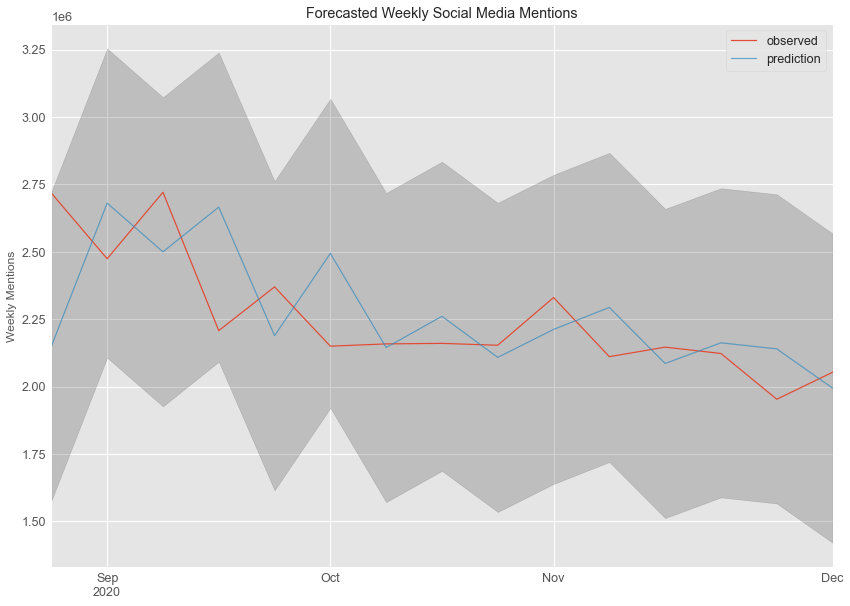

In [36]:
ax = val_weekly[val_weekly.index[0]:].mentions.plot(label= 'observed')
pred.predicted_mean.plot(ax=ax, label='prediction', alpha=.7, figsize=(14, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('')
ax.set_ylabel('Weekly Mentions')
ax.set_title('Forecasted Weekly Social Media Mentions')
plt.legend()
plt.show()

### SARIMAX Validation Results

In [37]:
acc_sarimax = forecast_accuracy(val_weekly.mentions, pred.predicted_mean)
acc_naive = forecast_accuracy(val_weekly.mentions, train_and_val_weekly.naive[-len(val_weekly):])
acc_avg = forecast_accuracy(val_weekly.mentions, train_and_val_weekly.average[-len(val_weekly):])
model_metrics = pd.DataFrame([acc_sarimax, acc_naive, acc_avg], index= ['SARIMAX', 'Naive', 'Average'])
model_metrics

,rmse,mape,r2
SARIMAX,242084.794401,8.001131,0.126414
Naive,213249.685757,7.079101,0.274228
Average,183680.464341,6.041832,0.325468


Across the board, the SARIMAX model performed the worst in all three metrics (RMSE, MAPE, $r^2$). The SARIMAX gridsearch of the hyperparameters appeared to prioritize higher order of `p`'s, and higher order of `q`'s appeared to decrease model performance with respect to AIC. Next, we'll look at how we might improve the model.

### Model Improvements and Robustness

#### User-Selected PDQs  

In an effort to improve the SARIMAX model, I used a lesser order `p` (the autoregressive term) and increased the order of `q` (the moving average term).

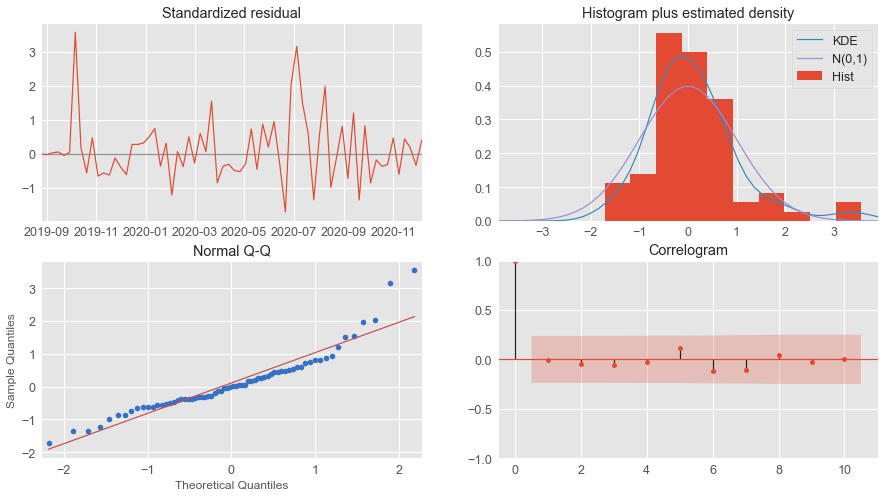

,rmse,mape,r2
SARIMAX,242084.794401,8.001131,0.126414
Naive,213249.685757,7.079101,0.274228
Average,183680.464341,6.041832,0.325468
raised_pq,207596.657958,7.847758,0.284532


In [38]:
new_order = (3, 1, 2)
model = sm.tsa.statespace.SARIMAX(train_and_val_weekly.mentions, order= new_order,
                                  seasonal_order= best_param.values[0][1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()
results.plot_diagnostics(figsize=(15, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime(val_weekly.index[0], utc= True), dynamic=False)
pd.DataFrame(forecast_accuracy(val_weekly.mentions, pred.predicted_mean), index= ['raised_pq'])
t = pd.DataFrame(forecast_accuracy(val_weekly.mentions, pred.predicted_mean), index= ['raised_pq'])
model_metrics = pd.concat([model_metrics, t])
model_metrics

In the table above, the new model is labeled "raised_pq". Every metric improved after manual tuning of the hyperparameters. By slightly adjusting the autoregressive and the moving average parameters, I was able to improve the model across all three metrics. I suspect that manual tuning was superior to gridsearch because the gridsearch loss function, AIC, is different than the loss functions we are optimizing on here (MAPE, RMSE, and $r^2$).

From the QQ plot, we can see another advantage of using the updated parameters is that the plot is "more" normal, as it better follows the red line. This is advantageous as many summary statistics are reliant on a Gaussian distribution to create any sort of generalizations.

#### Cross Validation via Walk-Forward Optimization

The image below is an example of how cross validation works with respect to time-series data. In blue, we have the training data, while in red we have the test data. One requirement is that the training data always precedes the test data. Note that the test data is a single point in time, also known as one-step forecasting.

![](tscv.png)

In [39]:
# one-step time series cross validation function
def time_series_cross_validation(data, n_splits= 5):
    
    true_values = []
    predictions = []
    
    tscv = TimeSeriesSplit(n_splits= n_splits)
    
    for train_index, test_index in tscv.split(data):
        train, test = timeseries.iloc[train_index], timeseries.iloc[test_index]

        model = sm.tsa.statespace.SARIMAX(train.mentions,
                                          order= (6, 1, 3),
                                          seasonal_order=best_param.values[0][1],
                                          enforce_stationarity= False,
                                          enforce_invertibility= False)

        results = model.fit()

        pred = results.get_forecast(1)
        predictions.append(pred.predicted_mean.values[0])
        true_values.append(test.mentions[0])

    return np.array(true_values), np.array(predictions)

In [40]:
true, pred = time_series_cross_validation(timeseries.mentions)
model_metrics = pd.concat([model_metrics, pd.DataFrame(forecast_accuracy(true, pred), index= ["cross-validation"])])
model_metrics

,rmse,mape,r2
SARIMAX,242084.794401,8.001131,0.126414
Naive,213249.685757,7.079101,0.274228
Average,183680.464341,6.041832,0.325468
raised_pq,207596.657958,7.847758,0.284532
cross-validation,34423.908016,40.868333,0.938597


The cross validated metrics are shown above as "cross-validation". The MAPE and RMSE are not comparable to the previous MAPEs and RMSEs because validation was done on only 5 points. We would expect variation to be high, especially given the volatility of the data.

What is interesting here is the $r^2$. The $r^2$ is a function of the covariance of the two variables (true and predicted), and the two variables' standard error. What this high $r^2$ is telling us (at least for the 5 points) is that our model and the 5 predicted time points are trending very similarly. This is a good sign as it tells us that the model is generalizing well to various train and validation splits.

## Random Forest

The final model used is the RandomForest regressor for time-series analysis. This was chosen because Random Forests are easy to explain, as each decision is essentially a single comparison. Furthermore, the nature of the data allows for extensive feature extraction from the data. From the date alone, we are able to pull the year, week, day, and weekday. Knowing the true social mentions, we are able to create lags and diffs (same as the lags and diffs from the ARIMA model) that can catch weekly seasonality that we saw indications of in the boxplots.

### Feature Extraction

We extract the features mentioned above.

In [41]:
# Labels
y = weekly.copy()

In [42]:
# Create features starting with lag 1 to capture weekly variation
X = y.shift(1).copy()
X.rename(columns= {'mentions': 'shift_1'}, inplace= True)

In [43]:
# Create the difference feature to extract stationarity
X[f"diff_1"] = y.diff()

In [44]:
y.reset_index(inplace= True)
X.reset_index(inplace= True)

In [45]:
# Extract date information
X["year"] = y.date.apply(lambda x: x.year)
X["week"] = y.date.apply(lambda x: x.week)
X["day"] = y.date.apply(lambda x: x.day)
X['weekday'] = y.date.apply(lambda x: x.weekday())

### Encoding Features

We encode the weekday (Mon-Sun) features because the values (0-6) do not actually mean anything and are just labels for the weekday.

In [46]:
columns = ["weekday"]
ohe = OneHotEncoder()
encoding = ohe.fit_transform(X[columns])
X = X.drop(columns, axis = 1)
X = pd.concat([X, pd.DataFrame(encoding.toarray())], axis = 1)

In [47]:
y.set_index('date', inplace= True)
X.set_index('date', inplace= True)

### Fill Missing Values

Most features are missing data from the front because of the shift and diff methods. I hypothesize that backfilling to replace the missing values will produce the best results.

In [48]:
X.fillna(method= 'bfill', inplace= True)

Previously, our training, development, and testing datasets were separated chronologically. With the Random Forest model, the historical data is already captured in the shifts and differencing extractions performed above. Therefore traditional train-test split methods apply here.

In [49]:
# split into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

y_train = y_train.values.ravel()
y_dev = y_dev.values.ravel()
y_test = y_test.values.ravel()

In [50]:
# Create base RF model
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
prediction = clf.predict(X_dev)
model_metrics = pd.concat([model_metrics, pd.DataFrame(forecast_accuracy(y_dev, prediction), index = ['RandomForest'])])

### Random Forest Validation Results

In [51]:
model_metrics.loc[['SARIMAX', 'Average', 'RandomForest']]

,rmse,mape,r2
SARIMAX,242084.794401,8.001131,0.126414
Average,183680.464341,6.041832,0.325468
RandomForest,101847.082066,28.346039,0.988199


The base Random Forest model has extremely promising results. The RMSE is 10x lower than the 2nd best performing model. The $r^2$ is much higher as well. The MAPE at 28% is quite high, meaning that when the RF model is incorrect, it is very incorrect. This may be due to the extreme jumps over time seen in the training data.

# Test Results

In [52]:
# Fit and predict SARIMAX on test set using best model
model = sm.tsa.statespace.SARIMAX(weekly.mentions,
                                  order= (3, 1, 2),
                                  seasonal_order= best_param.values[0][1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()
pred = results.get_prediction(start= pd.to_datetime(test_weekly.index[0], utc= True), dynamic=False)

# Predict RF on test set
prediction = clf.predict(X_test)

# Calculate Metrics
sarimax_test = forecast_accuracy(test_weekly.mentions, pred.predicted_mean)
rf_test = forecast_accuracy(y_test, prediction)

# Calculate metrics for naive and rolling average models
acc_naive = forecast_accuracy(test_weekly.mentions, test_weekly.naive[-len(test_weekly):])
acc_avg = forecast_accuracy(test_weekly.mentions, test_weekly.average[-len(test_weekly):])

model_metrics = pd.DataFrame([acc_naive, acc_avg, sarimax_test, rf_test], index= ['Naive', 'Average', "SARIMAX", 'RandomForest'])

model_metrics.round(2).sort_values('rmse')

,rmse,mape,r2
RandomForest,299590.23,21.07,0.88
Average,334448.90,38.78,0.77
SARIMAX,456824.01,49.43,0.35
Naive,535594.22,60.40,0.17


# Discussion and Future Plans

The Random Forest model produces the  most promising results!  

The RMSE is considerably lower than the rolling average model at 300,000, and the $r^2$ is much better as well. There is almost a 50% reduction in MAPE compared to the rolling average model. 

I suspect the added feature engineering done for the Random Forest model, as well as the added benefit of Random Forest being an ensemble method, gives it an extra boost over the SARIMAX model. 

Overall, the Random Forest model represents an easily explainable and scalable machine learning model that shows signs of generalizing well to future data. Moving forward, the Random Forest should be used as the new baseline for any additional models that will be considered for forecasting weekly social media mentions. 

## Hyperparameter Tuning

With additional time, I would hyperparameter tune the Random Forest using techiniques such as RandomizedSearchCV and GridSearchCV. Given even more time, I would do further research on Random Forest from [papers such as this one](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) to dive into how each hyperparameter should be tuned for best performance.

## Feature Engineering

We also see that our final SARIMAX model outperforms the Naive model on all metrics, but underperforms against the rolling average algorithm.  

As mentioned earlier, we were able to pull additional features (see section 5.3) out from the data that could have been used for statistical modeling as well. Given additional time, I would reevaluate the SARIMAX model using the new features, and also look at other statistical modeling approaches such as ARCH (autoregressive conditional heteroskedasticity) model, which takes into account nonuniform variance, and VAR (vector autoregression) model, which excels at multivariate forecasting.

# Appendix

## FAQs

### Why stationary data?

https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary

>The mean across many time periods is only informative if the expected value is the same across those time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

> (Weak) stationarity requires that these population quantities must be the same across time, making the sample average a reasonable way to estimate them.

>In addition to this, stationary processes avoid the problem of spurious regression (i.e. drawing wrong causal conclusions via ommited variable bias).

### What if train/test are not similar?

Because of how ARIMA models work, this is not as big of an issue for say something like a classification problem. ARIMA models use the last `p` and `q` points to determine the future points.

For Random Forest, all the historical data is built into the features so this is also not an issue.